In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import sys, getopt
import os
from glob import glob
import piexif
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd
from sklearn.model_selection import train_test_split
from HitNet import HitNet
from TrackNet3 import TrackNet3
from keras.models import *
from keras.layers import *
import keras.backend as K
from keras import optimizers
from keras.activations import *
import tensorflow as tf
import cv2
import math

In [ ]:
BATCH_SIZE=3
HEIGHT=288
WIDTH=512
mag = 1
sigma = 2.5

#Return the values of accuracy, precision and recall
def evaluation(y_pred, y_true, tol):
    (TP, TN, FP1, FP2, FN) = outcome(y_pred, y_true, tol)
    try:
        accuracy = (TP + TN) / (TP + TN + FP1 + FP2 + FN)
    except:
        accuracy = 0
    try:
        precision = TP / (TP + FP1 + FP2)
    except:
        precision = 0
    try:
        recall = TP / (TP + FN)
    except:
        recall = 0
    return (accuracy, precision, recall)

In [ ]:
def custom_loss(y_true, y_pred):
    loss = (-1)*(K.square(1 - y_pred) * y_true * K.log(K.clip(y_pred, K.epsilon(), 1)) + K.square(y_pred) * (1 - y_true) * K.log(K.clip(1 - y_pred, K.epsilon(), 1)))
    return K.mean(loss)

In [ ]:
load_weights = './model906_30'
save_weights = './hitnet_weights'

from HitNet import HitNet
tracknet_model = load_model(load_weights, custom_objects={'custom_loss':custom_loss})
model = HitNet(HEIGHT, WIDTH)

for l, layer in enumerate(tracknet_model.layers):
    if l >= len(model.layers)-model.ncustom:
        break
    model.layers[l].set_weights(layer.get_weights())
    model.layers[l].trainable = False

In [ ]:
model.compile(
    optimizer="adam", 
    loss="binary_crossentropy",
    metrics=['accuracy']
)
model.summary()

In [ ]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from glob import glob

import gc

epochs = 10
dataDir = '/home/code-base/scratch_space/data/npy-hitnet'
r = os.path.abspath(os.path.join(dataDir))
path = glob(os.path.join(r, '*.npy'))
num = len(path) / 2
idx = np.arange(num, dtype='int') + 1
print('Beginning training......')
for i in range(epochs):
    print('============epoch', i+1, '================')
    np.random.shuffle(idx)
#     for j in idx:
#         x_train = np.load(os.path.abspath(os.path.join(dataDir, 'x_data_' + str(j) + '.npy')))
#         y_train = np.load(os.path.abspath(os.path.join(dataDir, 'y_data_' + str(j) + '.npy')))
#         y_train = np.sum(y_train, axis=1)
        
# #         cw = class_weight.compute_class_weight('balanced', [0,1], y_train)
#         model.fit(
#             x_train, y_train, 
#             batch_size=BATCH_SIZE, 
#             epochs=5,
# #             class_weight=cw,
#             class_weight={0:1, 1:100},
#             shuffle=True,
#             validation_split=0.1)
        
#         del x_train
#         del y_train
#         gc.collect()
    
    y_all_pred, y_all_truth = [], []
    cnt = 0
    for j in idx:
        print(j, cnt, len(idx))
        cnt += 1
        x_inp = np.load(os.path.abspath(os.path.join(dataDir, 'x_data_' + str(j) + '.npy')))
        y_truth = np.load(os.path.abspath(os.path.join(dataDir, 'y_data_' + str(j) + '.npy')))
        y_truth = np.sum(y_truth, axis=1)
        
#         cw = class_weight.compute_class_weight('balanced', [0,1], y_train)
        y_pred = model.predict(x_inp) > 0.5
        
        y_all_truth.extend(y_truth)
        y_all_pred.extend(y_pred)
        
        del x_inp
        del y_truth
        gc.collect()
        
        if cnt % 11 == 10:
            print(classification_report(y_all_truth, y_all_pred))
        
    print(classification_report(y_all_truth, y_all_pred))
        
        
    #Save intermediate weights during training
    if (i + 1) % 3 == 0:
        model.save(save_weights + '_' + str(i + 1))

print('Saving weights......')
model.save(save_weights)
print('Done......')

In [ ]:
model.predict(x_train)

# Pixel coordinates-only net

In [ ]:
# Build model
dropout = 0.3
num_consec = 5
input_layer = Input(shape=(num_consec * 2,))
x = Dense(
    128, 
    activation='relu',
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(input_layer)
# x = Dropout(dropout)(x)
x = Dense(
    64, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)
x = Dense(
    32, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)
x = Dense(
    16, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)
output_layer = Dense(
    1, 
    activation='sigmoid',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)

model = Model(input_layer, output_layer)

In [ ]:
opt = optimizers.Adam(lr=1e-6)
model.compile(
    optimizer='adam', 
    loss="binary_crossentropy",
    metrics=['accuracy']
)
model.summary()

In [ ]:
def diffuse(x):
    for i in range(x.shape[0]):
        val = 0
        if i > 0:
            val += x[i-1]
        if i < x.shape[0]-1:
            val += x[i+1]
        x[i] = max(x[i], val/2.)
    return x

In [ ]:
matches = list('match' + str(i) for i in range(1, 23))

x_train, y_train = [], []
for match in matches:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        trajectory = pd.read_csv('/home/code-base/scratch_space/data/%s/ball_trajectory/%s_ball.csv' % (match, rally))
        hit = pd.read_csv('/home/code-base/scratch_space/data/%s/shot/%s_hit.csv' % (match, rally))
        trajectory[trajectory.X == 0] = float('nan')
        trajectory[trajectory.Y == 0] = float('nan')
        
        trajectory = trajectory.assign(X=trajectory.X.interpolate(method='slinear'))
        trajectory = trajectory.assign(Y=trajectory.Y.interpolate(method='slinear'))
        trajectory.fillna(method='bfill', inplace=True)
        trajectory.fillna(method='ffill', inplace=True)
        
        x_list, y_list = [], []
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))
            y = hit.hit[i:end].to_numpy().astype(float)
            x_list.append(x)
            y_list.append(y)
        
        x_t = np.hstack(x_list)
        y_t = np.sum(np.column_stack(y_list[1:-1]), axis=1)
        x_train.append(x_t)
        y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

Xb, Yb = trajectory.X.tolist(), trajectory.Y.tolist()
plt.plot(range(400), Yb[:400])
plt.plot(range(400), Xb[:400])
plt.show()

In [ ]:
import ruptures as rpt
rpt.display(trajectory.Y, hit.index[hit.hit == 1].tolist(), hit.index[hit.hit == 1].tolist())
rpt.display(trajectory.X, hit.index[hit.hit == 1].tolist(), hit.index[hit.hit == 1].tolist())

plt.show()

In [ ]:
import random

p = sum(y_train == 1) / sum(y_train == 0)
subsample = []
for i in range(x_train.shape[0]):
    if random.random() < p or y_train[i]:
        subsample.append(i)

x_sub = x_train[subsample]
y_sub = y_train[subsample]

In [ ]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

# cw = class_weight.compute_class_weight('balanced', [0,1], y_train)
model.fit(
    x_sub, y_sub, 
    batch_size=64, 
    epochs=1000,
#     class_weight={0: cw[0] / sum(cw), 1: 1.5 * cw[1] / sum(cw)},
    shuffle=True,
    validation_split=0.1,
    verbose=1)

In [ ]:
y_pred = np.round(model.predict(x_train) > 0.9)
print(classification_report(y_train, y_pred))

In [ ]:
import keras
keras.models.save_model(model, './hitnet_weights')

# Incorporating pose and court information

In [3]:
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.trajectory import Trajectory
from ai_badminton.video_annotator import annotate_video

<ipython-input-4-a0a7a1051503>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


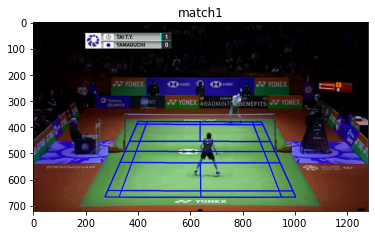

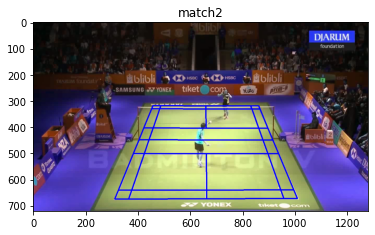

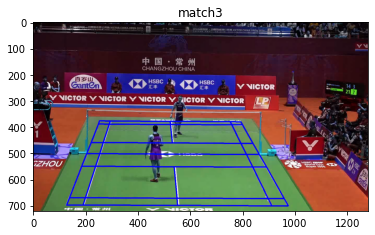

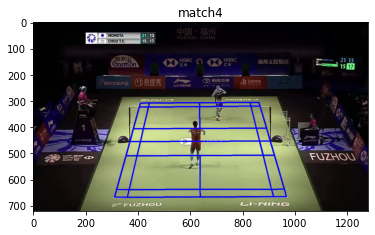

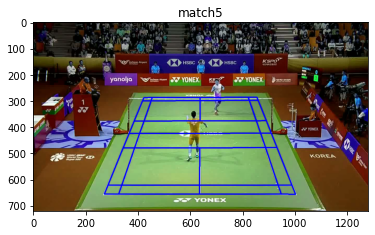

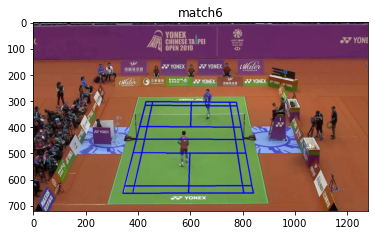

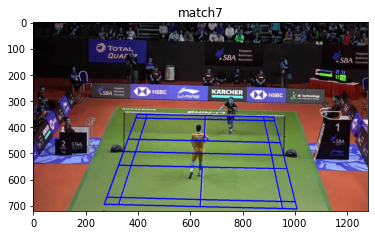

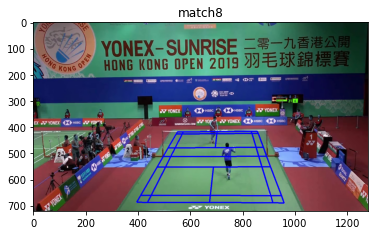

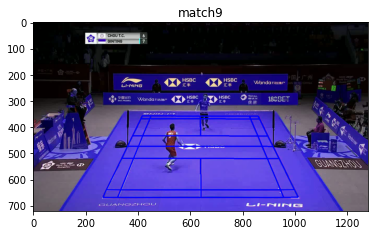

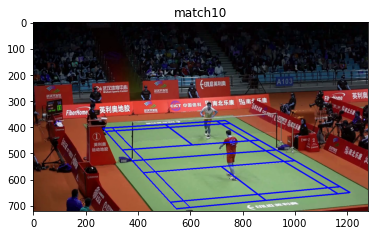

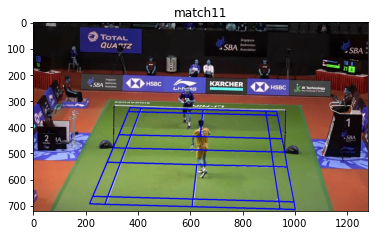

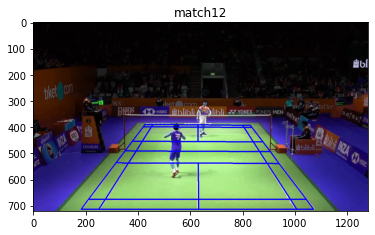

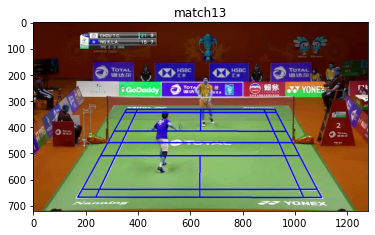

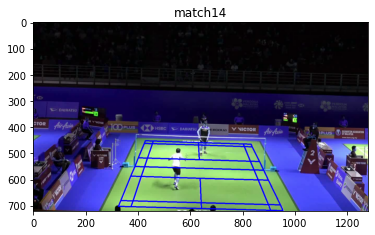

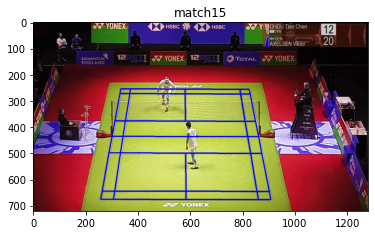

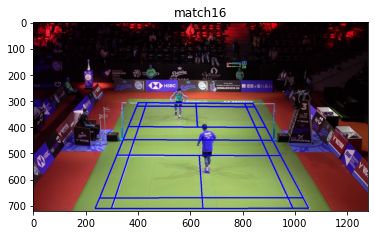

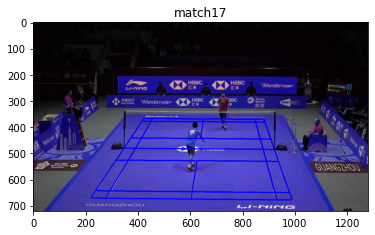

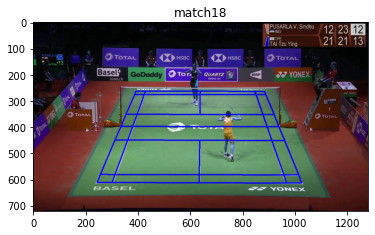

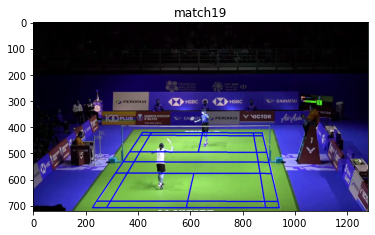

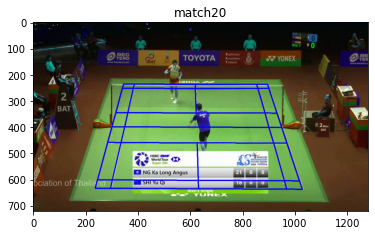

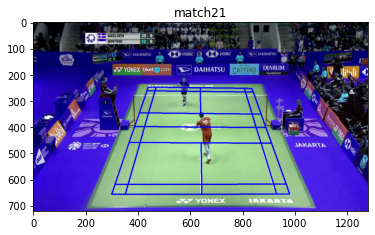

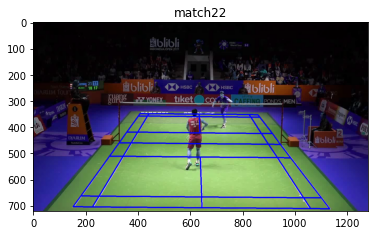

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

match = 'match21'
rally = '1_02_01'

import os
matches = list('match' + str(i) for i in range(1, 23))

for match in matches:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        
        court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
        corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
    
        def draw_court(corners):
            # Draws the court once we have the three corners
            court = Court(corners)
            frames[-1] = court.draw_lines(frames[-1])
            plt.imshow(frames[-1])
            plt.title(match)
   
        cap = cv2.VideoCapture('/home/code-base/scratch_space/data/%s/rally_video/%s.mp4' % (match, rally))
        if cap.isOpened() is False:
            print('Error opening video stream or file')

        ret, frame = cap.read()
        fig = plt.figure()
        frames = [frame]

        draw_court(corners)
        break
court = Court(corners)

In [5]:
poses = process_pose_file(
    '/home/code-base/scratch_space/data/%s/poses/%s.out' % (match, rally), 
    '/home/code-base/scratch_space/data/%s/poses/%s' % (match, rally), 
    court
)

Read in files. Processing poses...


  0%|          | 0/36797 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!


In [6]:
trajectory = Trajectory('/home/code-base/scratch_space/data/%s/ball_trajectory/%s_ball.csv' % (match, rally))
poses = read_player_poses('/home/code-base/scratch_space/data/%s/poses/%s' % (match, rally))
annotate_video(
    cap,
    court,
    poses,
    trajectory,
)

  0%|          | 0/645 [00:00<?, ?it/s]

In [8]:
import os
matches = list('match' + str(i) for i in range(1, 23))

for match in matches:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        
        court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
        corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
        court = Court(corners)
        
        print(match, rally)
        poses = process_pose_file(
            '/home/code-base/scratch_space/data/%s/poses/%s.out' % (match, rally), 
            '/home/code-base/scratch_space/data/%s/poses/%s' % (match, rally), 
            court
        )

match1 1_02_00
Read in files. Processing poses...


  0%|          | 0/42185 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_02_04
Read in files. Processing poses...


  0%|          | 0/12131 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_06_08
Read in files. Processing poses...


  0%|          | 0/8439 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_02_02
Read in files. Processing poses...


  0%|          | 0/21432 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_06_06
Read in files. Processing poses...


  0%|          | 0/12722 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_03_05
Read in files. Processing poses...


  0%|          | 0/30415 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_02_01
Read in files. Processing poses...


  0%|          | 0/14953 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_03_04
Read in files. Processing poses...


  0%|          | 0/11118 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_06_09
Read in files. Processing poses...


  0%|          | 0/37475 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_02_03
Read in files. Processing poses...


  0%|          | 0/6876 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_03_06
Read in files. Processing poses...


  0%|          | 0/20837 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match1 1_01_00
Read in files. Processing poses...


  0%|          | 0/52840 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match2 1_00_02
Read in files. Processing poses...


  0%|          | 0/17040 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match2 1_08_11
Read in files. Processing poses...


  0%|          | 0/10052 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match2 1_06_08
Read in files. Processing poses...


  0%|          | 0/10962 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match2 1_09_12
Read in files. Processing poses...


  0%|          | 0/12837 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match2 1_08_12
Read in files. Processing poses...


  0%|          | 0/8605 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match2 1_04_03
Read in files. Processing poses...


  0%|          | 0/9650 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match2 1_06_09
Read in files. Processing poses...


  0%|          | 0/14797 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match2 1_02_03
Read in files. Processing poses...


  0%|          | 0/10147 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match3 2_04_07
Read in files. Processing poses...


  0%|          | 0/50123 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match3 2_18_15
Read in files. Processing poses...


  0%|          | 0/86556 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match3 1_12_17
Read in files. Processing poses...


  0%|          | 0/27533 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match3 3_11_10
Read in files. Processing poses...


  0%|          | 0/16789 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match3 2_10_12
Read in files. Processing poses...


  0%|          | 0/16033 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match3 1_08_10
Read in files. Processing poses...


  0%|          | 0/11365 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match3 1_01_00
Read in files. Processing poses...


  0%|          | 0/36305 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match4 2_14_17
Read in files. Processing poses...


  0%|          | 0/8494 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match4 3_07_05
Read in files. Processing poses...


  0%|          | 0/6486 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match4 3_02_00
Read in files. Processing poses...


  0%|          | 0/14829 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match4 2_02_05
Read in files. Processing poses...


  0%|          | 0/17186 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match4 3_18_17
Read in files. Processing poses...


  0%|          | 0/22839 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match4 1_15_10
Read in files. Processing poses...


  0%|          | 0/15965 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match4 1_03_02
Read in files. Processing poses...


  0%|          | 0/15032 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match4 2_05_07
Read in files. Processing poses...


  0%|          | 0/15113 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match5 1_01_01
Read in files. Processing poses...


  0%|          | 0/70571 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match5 1_01_02
Read in files. Processing poses...


  0%|          | 0/49213 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match5 1_19_18
Read in files. Processing poses...


  0%|          | 0/25306 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match5 2_15_13
Read in files. Processing poses...


  0%|          | 0/43326 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match5 2_20_17
Read in files. Processing poses...


  0%|          | 0/56759 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match5 1_21_19
Read in files. Processing poses...


  0%|          | 0/68717 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match6 1_02_00
Read in files. Processing poses...


  0%|          | 0/42433 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match6 1_11_04
Read in files. Processing poses...


  0%|          | 0/49904 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match6 1_15_06
Read in files. Processing poses...


  0%|          | 0/68661 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match6 1_05_03
Read in files. Processing poses...


  0%|          | 0/83808 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match6 1_19_12
Read in files. Processing poses...


  0%|          | 0/27812 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match7 2_14_15
Read in files. Processing poses...


  0%|          | 0/49821 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match7 1_02_01
Read in files. Processing poses...


  0%|          | 0/60849 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match7 1_12_13
Read in files. Processing poses...


  0%|          | 0/70833 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match7 3_08_05
Read in files. Processing poses...


  0%|          | 0/46532 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match7 2_05_03
Read in files. Processing poses...


  0%|          | 0/94493 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match8 2_03_06
Read in files. Processing poses...


  0%|          | 0/69650 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match8 3_02_00
Read in files. Processing poses...


  0%|          | 0/5598 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match8 3_15_08
Read in files. Processing poses...


  0%|          | 0/9930 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match8 2_10_12
Read in files. Processing poses...


  0%|          | 0/34392 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match8 3_17_12
Read in files. Processing poses...


  0%|          | 0/34937 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match8 1_05_13
Read in files. Processing poses...


  0%|          | 0/13828 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match8 3_21_13
Read in files. Processing poses...


  0%|          | 0/18715 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match8 1_01_00
Read in files. Processing poses...


  0%|          | 0/20075 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_07_07
Read in files. Processing poses...


  0%|          | 0/19468 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_01_03
Read in files. Processing poses...


  0%|          | 0/57739 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_06_06
Read in files. Processing poses...


  0%|          | 0/18033 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_07_14
Read in files. Processing poses...


  0%|          | 0/13939 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_07_10
Read in files. Processing poses...


  0%|          | 0/38480 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_05_06
Read in files. Processing poses...


  0%|          | 0/18299 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_02_03
Read in files. Processing poses...


  0%|          | 0/22095 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_07_11
Read in files. Processing poses...


  0%|          | 0/18835 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match9 1_04_05
Read in files. Processing poses...


  0%|          | 0/18675 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match10 1_12_16
Read in files. Processing poses...


  0%|          | 0/47682 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match10 1_03_03
Read in files. Processing poses...


  0%|          | 0/47622 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match10 2_14_08
Read in files. Processing poses...


  0%|          | 0/53612 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match10 1_03_01
Read in files. Processing poses...


  0%|          | 0/57399 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match10 2_04_02
Read in files. Processing poses...


  0%|          | 0/25910 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match11 2_05_00
Read in files. Processing poses...


  0%|          | 0/35413 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match11 1_03_01
Read in files. Processing poses...


  0%|          | 0/50357 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match11 1_13_13
Read in files. Processing poses...


  0%|          | 0/58056 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match11 2_15_04
Read in files. Processing poses...


  0%|          | 0/54649 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match11 1_07_06
Read in files. Processing poses...


  0%|          | 0/30156 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match12 1_10_12
Read in files. Processing poses...


  0%|          | 0/54107 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match12 3_03_03
Read in files. Processing poses...


  0%|          | 0/27707 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match12 2_01_01
Read in files. Processing poses...


  0%|          | 0/30556 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match12 2_05_14
Read in files. Processing poses...


  0%|          | 0/47307 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match12 1_01_00
Read in files. Processing poses...


  0%|          | 0/42977 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match13 2_09_08
Read in files. Processing poses...


  0%|          | 0/15721 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match13 1_09_10
Read in files. Processing poses...


  0%|          | 0/55558 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match13 1_17_15
Read in files. Processing poses...


  0%|          | 0/31162 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match13 2_06_05
Read in files. Processing poses...


  0%|          | 0/100992 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match13 2_17_11
Read in files. Processing poses...


  0%|          | 0/48043 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match13 2_07_05
Read in files. Processing poses...


  0%|          | 0/22418 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match14 2_21_17
Read in files. Processing poses...


  0%|          | 0/24929 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match14 2_15_10
Read in files. Processing poses...


  0%|          | 0/18952 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match14 2_13_06
Read in files. Processing poses...


  0%|          | 0/29932 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match14 2_19_13
Read in files. Processing poses...


  0%|          | 0/40255 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match14 1_17_14
Read in files. Processing poses...


  0%|          | 0/45742 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match15 1_21_12
Read in files. Processing poses...


  0%|          | 0/26484 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match15 2_14_08
Read in files. Processing poses...


  0%|          | 0/14556 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match15 2_19_14
Read in files. Processing poses...


  0%|          | 0/39461 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match15 2_16_12
Read in files. Processing poses...


  0%|          | 0/36078 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match15 2_18_14
Read in files. Processing poses...


  0%|          | 0/59222 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match16 1_13_20
Read in files. Processing poses...


  0%|          | 0/41407 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match16 3_14_09
Read in files. Processing poses...


  0%|          | 0/26117 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match16 3_12_06
Read in files. Processing poses...


  0%|          | 0/52825 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match16 1_03_06
Read in files. Processing poses...


  0%|          | 0/52360 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match16 2_08_08
Read in files. Processing poses...


  0%|          | 0/42718 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match16 3_17_16
Read in files. Processing poses...


  0%|          | 0/34788 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match17 1_15_13
Read in files. Processing poses...


  0%|          | 0/48714 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match17 2_08_05
Read in files. Processing poses...


  0%|          | 0/53810 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match17 1_02_02
Read in files. Processing poses...


  0%|          | 0/33984 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match17 2_18_11
Read in files. Processing poses...


  0%|          | 0/50470 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match17 2_01_01
Read in files. Processing poses...


  0%|          | 0/53873 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match17 2_15_11
Read in files. Processing poses...


  0%|          | 0/44885 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match18 3_12_14
Read in files. Processing poses...


  0%|          | 0/33939 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match18 3_03_05
Read in files. Processing poses...


  0%|          | 0/59311 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match18 3_20_19
Read in files. Processing poses...


  0%|          | 0/31082 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match18 2_02_02
Read in files. Processing poses...


  0%|          | 0/33844 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match18 1_06_12
Read in files. Processing poses...


  0%|          | 0/32794 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match18 3_16_17
Read in files. Processing poses...


  0%|          | 0/31388 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match19 1_01_01
Read in files. Processing poses...


  0%|          | 0/40076 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match19 2_12_06
Read in files. Processing poses...


  0%|          | 0/39210 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match19 2_14_08
Read in files. Processing poses...


  0%|          | 0/36181 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match19 1_01_03
Read in files. Processing poses...


  0%|          | 0/75371 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match19 1_07_08
Read in files. Processing poses...


  0%|          | 0/37888 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match20 2_00_01
Read in files. Processing poses...


  0%|          | 0/27823 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match20 1_09_05
Read in files. Processing poses...


  0%|          | 0/57081 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match20 2_05_08
Read in files. Processing poses...


  0%|          | 0/67148 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match20 2_19_14
Read in files. Processing poses...


  0%|          | 0/43132 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match20 2_07_08
Read in files. Processing poses...


  0%|          | 0/35874 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match20 1_11_10
Read in files. Processing poses...


  0%|          | 0/40181 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match21 2_09_08
Read in files. Processing poses...


  0%|          | 0/27105 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match21 2_02_03
Read in files. Processing poses...


  0%|          | 0/21617 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match21 1_19_19
Read in files. Processing poses...


  0%|          | 0/8807 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match21 2_12_08
Read in files. Processing poses...


  0%|          | 0/15419 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match21 1_02_01
Read in files. Processing poses...


  0%|          | 0/16731 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match21 1_16_17
Read in files. Processing poses...


  0%|          | 0/25143 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match21 2_04_04
Read in files. Processing poses...


  0%|          | 0/18639 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match22 2_17_18
Read in files. Processing poses...


  0%|          | 0/36797 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match22 3_15_13
Read in files. Processing poses...


  0%|          | 0/24871 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match22 1_02_01
Read in files. Processing poses...


  0%|          | 0/55149 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match22 2_18_18
Read in files. Processing poses...


  0%|          | 0/30512 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!
match22 1_07_02
Read in files. Processing poses...


  0%|          | 0/23406 [00:00<?, ?it/s]

Separating top and bottom poses...
Done!


# Creating a neural net that uses pose and court information

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2

def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

num_consec = 5
matches = list('match' + str(i) for i in range(1, 23))

from sklearn.preprocessing import MinMaxScaler, StandardScaler

x_train, y_train = [], []
for match in matches:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        cap = cv2.VideoCapture('/home/code-base/scratch_space/data/%s/rally_video/%s' % (match, video))
        shape = cap.read()[1].shape
        height, width = shape[1], shape[0]

        rally, _ = os.path.splitext(video)
        trajectory = pd.read_csv('/home/code-base/scratch_space/data/%s/ball_trajectory/%s_ball.csv' % (match, rally))
        hit = pd.read_csv('/home/code-base/scratch_space/data/%s/shot/%s_hit.csv' % (match, rally))
        trajectory[trajectory.X == 0] = float('nan')
        trajectory[trajectory.Y == 0] = float('nan')
        
        trajectory = trajectory.assign(X=trajectory.X.interpolate(method='slinear'))
        trajectory = trajectory.assign(Y=trajectory.Y.interpolate(method='slinear'))
        trajectory.fillna(method='bfill', inplace=True)
        trajectory.fillna(method='ffill', inplace=True)
        
        bottom_player = pd.read_csv('/home/code-base/scratch_space/data/%s/poses/%s_bottom.csv' % (match, rally))
        top_player = pd.read_csv('/home/code-base/scratch_space/data/%s/poses/%s_top.csv' % (match, rally))
        bottom_player.drop('frame', axis=1, inplace=True)
        top_player.drop('frame', axis=1, inplace=True)
        bottom_player.fillna(0, inplace=True)
        top_player.fillna(0, inplace=True)
        
        x_list, y_list = [], []
        court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
        corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
    
        def reflect(x):
            x_ = np.array(x)
            for i in range(0, x.shape[1], 2):
                x_[:, i] = width - x_[:, i]
            return x_

        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))
            
            # Reduce amount of data by averaging coordinate values
#             bottom_x = np.median(bottom_player.values[i:end][:, ::2], axis=1)
#             bottom_y = np.median(bottom_player.values[i:end][:, 1::2], axis=1)
#             top_x = np.median(top_player.values[i:end][:, ::2], axis=1)
#             top_y = np.median(top_player.values[i:end][:, 1::2], axis=1)
            
            # Use median values only
#             x_pose = np.vstack([bottom_x, bottom_y, top_x, top_y]).T

            # Use entire pose
            x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
            x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])
#             x = np.hstack([x_bird, np.array([corners for j in range(i, end)])])
            y = hit.hit[i:end].to_numpy().astype(float)
            x_list.append(x)
            y_list.append(y)

        x_t = np.hstack(x_list)
        y_t = np.sum(np.column_stack(y_list[1:-1]), axis=1)
        
#         scaler = MinMaxScaler()
#         scaler.fit(x_t)
#         x_t = scaler.transform(x_t)
#         x_train.append(x_t)
#         y_train.append(y_t)
        
#         scaler = MinMaxScaler()
#         scaler.fit(reflect(x_t))
#         x_t = scaler.transform(reflect(x_t))
#         x_train.append(x_t)
#         y_train.append(y_t)

        x_train.append(x_t)
        y_train.append(y_t)
        x_train.append(reflect(x_t))
        y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

In [ ]:
from keras.models import *
from keras.layers import *
import keras.backend as K
from keras import optimizers
from keras.activations import *
import tensorflow as tf
import cv2
import math

dropout = 0.4

input_layer = Input(shape=(x_train[0].shape[0],))
x = Dense(
    70, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-9)
)(input_layer)
# x = ActivityRegularization(l1=1e-9)(x)
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
x = Dense(
    30, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-9)
)(x)
# x = Dropout(dropout)(x)

# x = ActivityRegularization(l1=1e-9)(x)
# x = ActivityRegularization()(x)
# x = BatchNormalization()(x)

# x = Dense(
#     32, 
#     activation='relu',
# #     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
# )(x)
# # x = ActivityRegularization(l1=1e-11)(x)
# x = BatchNormalization()(x)

# x = Dense(
#     16, 
#     activation='relu',
# #     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
# )(x)
# x = BatchNormalization()(x)

output_layer = Dense(
    1, 
    activation='sigmoid',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)

model = Model(input_layer, output_layer)

In [ ]:
opt = optimizers.Adam(lr=1e-1)
model.compile(
    optimizer='adam', 
    loss="binary_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)
model.summary()

In [ ]:
import random

p = sum(y_train == 1) / sum(y_train == 0)
subsample = []
for i in range(x_train.shape[0]):
    if random.random() < p or y_train[i]:
        subsample.append(i)

x_sub = x_train[subsample]
y_sub = y_train[subsample]

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_sub, y_sub, test_size=0.1, shuffle=True)

In [ ]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

# from keras import backend as K
# K.set_value(model.optimizer.learning_rate, 1e-5)

model.fit(
    x_tr, y_tr, 
    batch_size=64, 
    epochs=1000,
    shuffle=True,
    validation_data=(x_val, y_val),
    verbose=1)

In [ ]:
y_pred = np.round(model.predict(x_train) > 0.7)
print(classification_report(y_train, y_pred))

In [ ]:
import keras
keras.models.save_model(model, './hitnet_plus_court_model')

# Conv. nets for shuttle detection

In [11]:
from keras import objectives, backend as K
import keras
import tensorflow as tf

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(
    device_count={ 'CPU': 16 , 'GPU':4},
    inter_op_parallelism_threads=0,
    allow_soft_placement=True,
    gpu_options= {'allow_growth': True, 'visible_device_list': "0,1,2,3"},
    intra_op_parallelism_threads=0,
))

K.set_session(sess)

In [41]:
x_train[0].shape[0] / num_consec / 2

39.0

In [7]:
from keras.models import *
from keras.layers import *
import keras.backend as K
from keras import optimizers
from keras.activations import *
import tensorflow as tf
import cv2
import math

drop = 0.3

input_layer = Input(shape=(x_train[0].shape[0],))
x = Reshape(target_shape=(num_consec, x_train[0].shape[0] // (2 * num_consec), 2, 1))(input_layer)
x = Conv3D(
    filters=40,
    kernel_size=(1, 39, 2),
    kernel_initializer='he_uniform',
    activation='relu',
    data_format="channels_last",
    kernel_regularizer=regularizers.l2(1e-8),
)(x)
x_base = Reshape(target_shape=(num_consec, 40))(x)
x2 = Conv1D(
    filters=32,
    kernel_size=2,
    kernel_initializer='he_uniform',
    activation='relu',
)(x_base)
x2 = Dense(
    16,
    activation='relu'
)(Flatten()(x2))
# x = Dropout(drop)(x)
x3 = Conv1D(
    filters=24,
    kernel_size=3,
    kernel_initializer='he_uniform',
    activation='relu',
)(x_base)
x3 = Dense(
    8,
    activation='relu'
)(Flatten()(x3))
x4 = Conv1D(
    filters=16,
    kernel_size=4,
    kernel_initializer='he_uniform',
    activation='relu',
)(x_base)
x4 = Dense(
    4,
    activation='relu'
)(Flatten()(x4))
xmax = Conv1D(
    filters=6,
    kernel_size=num_consec,
    kernel_initializer='he_uniform',
    activation='relu',
)(x_base)
xmax = Dense(
    1,
    activation='relu'
)(Flatten()(xmax))

x = Concatenate()([x2, x3, x4, xmax])
output_layer = Dense(
    3, 
    activation='softmax',
)(x)

model = Model(input_layer, output_layer)

In [8]:
model.compile(
    optimizer='adam', 
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 546)]        0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 7, 39, 2, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 7, 1, 1, 40)  3160        reshape_2[0][0]                  
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 7, 40)        0           conv3d_1[0][0]                   
____________________________________________________________________________________________

In [9]:
import random

p = sum(y_train > 0) / sum(y_train == 0)
subsample = []
for i in range(x_train.shape[0]):
    if random.random() < p or y_train[i]:
        subsample.append(i)

x_sub = x_train[subsample]
y_sub = y_train[subsample]

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_sub, y_sub, test_size=0.05, shuffle=True)

In [92]:
# from keras import backend as K
# K.set_value(model.optimizer.learning_rate, 1e-4)

model.fit(
    x_tr, y_tr, 
    batch_size=32, 
    epochs=1000,
#     class_weight={0: 0.08, 1: 2, 2: 2},
    shuffle=True,
    validation_data=(x_val, y_val),
    verbose=1)

Epoch 1/1000
766/766 [==============================] - 3s 4ms/step - loss: 0.3108 - accuracy: 0.8951 - val_loss: 0.3070 - val_accuracy: 0.8977
Epoch 2/1000
766/766 [==============================] - 3s 4ms/step - loss: 0.3122 - accuracy: 0.8922 - val_loss: 0.3128 - val_accuracy: 0.8953
Epoch 3/1000
766/766 [==============================] - 3s 4ms/step - loss: 0.3133 - accuracy: 0.8899 - val_loss: 0.3101 - val_accuracy: 0.8922
Epoch 4/1000
766/766 [==============================] - 3s 5ms/step - loss: 0.3067 - accuracy: 0.8956 - val_loss: 0.3140 - val_accuracy: 0.8984
Epoch 5/1000
766/766 [==============================] - 3s 4ms/step - loss: 0.3066 - accuracy: 0.8952 - val_loss: 0.3271 - val_accuracy: 0.8884
Epoch 6/1000
766/766 [==============================] - 3s 4ms/step - loss: 0.3056 - accuracy: 0.8951 - val_loss: 0.3092 - val_accuracy: 0.8946
Epoch 7/1000
766/766 [==============================] - 3s 4ms/step - loss: 0.3077 - accuracy: 0.8952 - val_loss: 0.3184 - val_accuracy:

KeyboardInterrupt: 

In [11]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(x_val), axis=1)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       646
           1       0.86      0.90      0.88       334
           2       0.82      0.79      0.80       310

    accuracy                           0.89      1290
   macro avg       0.87      0.88      0.87      1290
weighted avg       0.89      0.89      0.89      1290



In [96]:
os.chdir('/home/code-base/user_space/ai-badminton/TrackNetv2/3_in_3_out')

In [13]:
tf.keras.models.save_model(model, './hitnet_conv_model_predict_player2.h5', overwrite=True)

# Look at mis-predicted shots

In [100]:
os.getcwd()
os.chdir('/home/code-base/user_space/ai-badminton/notebooks')

In [102]:
frame[1,2]

array([4, 0, 3], dtype=uint8)

In [109]:
bottom_player.values.iloc[0]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [110]:
outvid = cv2.VideoWriter('./output/mispredicted.mp4', cv2.VideoWriter_fourcc('M','P','4','V'), 10, (width, height))

for match in matches[:5]:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        cap = cv2.VideoCapture('/home/code-base/scratch_space/data/%s/rally_video/%s' % (match, video))
        shape = cap.read()[1].shape
        height, width = shape[0], shape[1]

        rally, _ = os.path.splitext(video)
        trajectory = pd.read_csv('/home/code-base/scratch_space/data/%s/ball_trajectory/%s_ball.csv' % (match, rally))
        hit = pd.read_csv('/home/code-base/scratch_space/data/%s/shot/%s_hit.csv' % (match, rally))
        trajectory[trajectory.X == 0] = float('nan')
        trajectory[trajectory.Y == 0] = float('nan')
        
        trajectory = trajectory.assign(X=trajectory.X.interpolate(method='slinear'))
        trajectory = trajectory.assign(Y=trajectory.Y.interpolate(method='slinear'))
        trajectory.fillna(method='bfill', inplace=True)
        trajectory.fillna(method='ffill', inplace=True)
        
        bottom_player = pd.read_csv('/home/code-base/scratch_space/data/%s/poses/%s_bottom.csv' % (match, rally))
        top_player = pd.read_csv('/home/code-base/scratch_space/data/%s/poses/%s_top.csv' % (match, rally))
        bottom_player.drop('frame', axis=1, inplace=True)
        top_player.drop('frame', axis=1, inplace=True)
        bottom_player.fillna(0, inplace=True)
        top_player.fillna(0, inplace=True)
        
        x_list, y_list = [], []
        court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
        corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()

        # Identify first hit by distance to pose
        # and then alternate hits
        def dist_to_pose(pose, p):
            pose = pose.reshape(17, 2)
            p = p.reshape(1, 2)
            D = np.sum((pose - p) * (pose - p), axis=1)
            return min(D)
        
        y_new = np.array(hit.hit.to_numpy())
        last = -1
        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue
                
            if last == -1:
                p = np.array([trajectory.X[i], trajectory.Y[i]])
                db = dist_to_pose(bottom_player.values[i], p)
                dt = dist_to_pose(top_player.values[i], p)
                ratio = max((db/dt)**0.5, (dt/db)**0.5)
                
                if dt < db:
                    y_new[i] = 2
                else:
                    y_new[i] = 1
                last = y_new[i]
                
                # Bad cases are all 2's
                if 0.9 < ratio < 1.1:
                    y_new[i] = 1
                print('Check', match, video, last)
            else:
                y_new[i] = 3 - last
                last = y_new[i]
        
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

            # Use entire pose
            x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
            x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])

            y = y_new[i:end]
            x_list.append(x)
            y_list.append(y)

        x_t = np.hstack(x_list)
        y_t = np.max(np.column_stack(y_list[2:-2]), axis=1)
        y_pred = np.argmax(model.predict(x_t), axis=1)
        
        nframes = len(hit.hit)
        is_bad = [0] * nframes
        for i in range(y_t.shape[0]):
            if y_t[i] > 0 and y_t[i] != y_pred[i]:
                for j in range(max(0, i-20), min(nframes, i+20)):
                    if abs(j-i) < 4:
                        if y_pred[i] > 0:
                            is_bad[j] = 3
                        else:
                            is_bad[j] = 2
                    elif is_bad[j] == 0:
                        is_bad[j] = 1
        
        for i in range(nframes):
            if is_bad[i]:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if is_bad[i] == 3:
                    frame[-50:, -50:] = np.array([255, 0, 0])
                elif is_bad[i] == 2:
                    frame[-50:, -50:] = np.array([0, 0, 255])
                    
                centre = (int(trajectory.X[i]), int(trajectory.Y[i]))
                radius = 5
                colour = (0, 255, 0)
                thickness = -1
                frame = cv2.circle(frame, centre, radius, colour, thickness)
                
                players = [bottom_player.values, top_player.values]
                for j in range(2):
                    xy = players[j][i]
                    pose = Pose()
                    pose.init_from_kparray(xy)
                    player_poses.append(pose)
                    frame = pose.draw_skeleton(frame, colour=(128, 128 + j * 127, 128))
                outvid.write(frame)
outvid.release()

Check match1 1_01_00.mp4 2
Check match1 1_03_06.mp4 1
Check match1 1_02_04.mp4 2
Check match1 1_02_03.mp4 1
Check match1 1_02_00.mp4 1
Check match1 1_06_09.mp4 2
Check match1 1_02_02.mp4 1
Check match1 1_03_04.mp4 2
Check match1 1_06_08.mp4 1
Check match1 1_03_05.mp4 2
Check match1 1_06_06.mp4 2
Check match1 1_02_01.mp4 2
Check match2 1_00_02.mp4 1
Check match2 1_02_03.mp4 2
Check match2 1_06_09.mp4 2
Check match2 1_09_12.mp4 1
Check match2 1_08_12.mp4 2
Check match2 1_06_08.mp4 1
Check match2 1_08_11.mp4 1
Check match2 1_04_03.mp4 2
Check match3 1_01_00.mp4 2
Check match3 3_11_10.mp4 2
Check match3 2_04_07.mp4 2
Check match3 2_10_12.mp4 1
Check match3 1_08_10.mp4 2
Check match3 2_18_15.mp4 2
Check match3 1_12_17.mp4 2
Check match4 3_07_05.mp4 2
Check match4 2_14_17.mp4 2
Check match4 1_15_10.mp4 2
Check match4 2_02_05.mp4 2
Check match4 1_03_02.mp4 2
Check match4 2_05_07.mp4 2
Check match4 3_02_00.mp4 2
Check match4 3_18_17.mp4 2
Check match5 1_19_18.mp4 2
Check match5 2_20_17.mp4 1
C

# Create network to identify who hit the shuttle

In [2]:
import os
import pandas as pd
import numpy as np
import cv2

def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

num_consec = 7
matches = list('match' + str(i) for i in range(1, 23))

from sklearn.preprocessing import MinMaxScaler, StandardScaler

x_train, y_train = [], []
for match in matches:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        cap = cv2.VideoCapture('/home/code-base/scratch_space/data/%s/rally_video/%s' % (match, video))
        shape = cap.read()[1].shape
        height, width = shape[0], shape[1]

        rally, _ = os.path.splitext(video)
        trajectory = pd.read_csv('/home/code-base/scratch_space/data/%s/ball_trajectory/%s_ball.csv' % (match, rally))
        hit = pd.read_csv('/home/code-base/scratch_space/data/%s/shot/%s_hit.csv' % (match, rally))
        trajectory[trajectory.X == 0] = float('nan')
        trajectory[trajectory.Y == 0] = float('nan')
        
        trajectory = trajectory.assign(X=trajectory.X.interpolate(method='slinear'))
        trajectory = trajectory.assign(Y=trajectory.Y.interpolate(method='slinear'))
        trajectory.fillna(method='bfill', inplace=True)
        trajectory.fillna(method='ffill', inplace=True)
        
        bottom_player = pd.read_csv('/home/code-base/scratch_space/data/%s/poses/%s_bottom.csv' % (match, rally))
        top_player = pd.read_csv('/home/code-base/scratch_space/data/%s/poses/%s_top.csv' % (match, rally))
        bottom_player.drop('frame', axis=1, inplace=True)
        top_player.drop('frame', axis=1, inplace=True)
        bottom_player.fillna(0, inplace=True)
        top_player.fillna(0, inplace=True)
        
        x_list, y_list = [], []
        court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
        corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
    
        def reflect(x):
            x_ = np.array(x)
            for i in range(0, x.shape[1], 2):
                x_[:, i] = width - x_[:, i]
            return x_

        # Identify first hit by distance to pose
        # and then alternate hits
        def dist_to_pose(pose, p):
            pose = pose.reshape(17, 2)
            p = p.reshape(1, 2)
            D = np.sum((pose - p) * (pose - p), axis=1)
            return min(D)
        
        y_new = np.array(hit.hit.to_numpy())
        last = -1
        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue
                
            if last == -1:
                p = np.array([trajectory.X[i], trajectory.Y[i]])
                db = dist_to_pose(bottom_player.values[i], p)
                dt = dist_to_pose(top_player.values[i], p)
                ratio = max((db/dt)**0.5, (dt/db)**0.5)
                
                if dt < db:
                    y_new[i] = 2
                else:
                    y_new[i] = 1
                last = y_new[i]
                
                # Bad cases are all 2's
                if 0.9 < ratio < 1.1:
                    y_new[i] = 1
                print('Check', match, video, last)
            else:
                y_new[i] = 3 - last
                last = y_new[i]
        
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))
            
            # Reduce amount of data by averaging coordinate values
#             bottom_x = np.median(bottom_player.values[i:end][:, ::2], axis=1)
#             bottom_y = np.median(bottom_player.values[i:end][:, 1::2], axis=1)
#             top_x = np.median(top_player.values[i:end][:, ::2], axis=1)
#             top_y = np.median(top_player.values[i:end][:, 1::2], axis=1)
            
            # Use median values only
#             x_pose = np.vstack([bottom_x, bottom_y, top_x, top_y]).T

            # Use entire pose
            x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
            x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])
#             x = np.hstack([x_bird, np.array([corners for j in range(i, end)])])
            y = y_new[i:end]
            x_list.append(x)
            y_list.append(y)

        x_t = np.hstack(x_list)
        x_t_alt = np.array(x_t)
        y_t = np.max(np.column_stack(y_list[2:-2]), axis=1)
        
#         scaler = MinMaxScaler()
#         scaler.fit(x_t)
#         x_t = scaler.transform(x_t)
#         x_train.append(x_t)
#         y_train.append(y_t)
        
#         scaler = MinMaxScaler()
#         scaler.fit(reflect(x_t_alt))
#         x_t_alt = scaler.transform(reflect(x_t_alt))
#         x_train.append(x_t_alt)
#         y_train.append(y_t)

        x_train.append(x_t)
        y_train.append(y_t)
        x_train.append(reflect(x_t))
        y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

Check match1 1_01_00.mp4 2
Check match1 1_03_06.mp4 1
Check match1 1_02_04.mp4 2
Check match1 1_02_03.mp4 1
Check match1 1_02_00.mp4 1
Check match1 1_06_09.mp4 2
Check match1 1_02_02.mp4 1
Check match1 1_03_04.mp4 2
Check match1 1_06_08.mp4 1
Check match1 1_03_05.mp4 2
Check match1 1_06_06.mp4 2
Check match1 1_02_01.mp4 2
Check match2 1_00_02.mp4 1
Check match2 1_02_03.mp4 2
Check match2 1_06_09.mp4 2
Check match2 1_09_12.mp4 1
Check match2 1_08_12.mp4 2
Check match2 1_06_08.mp4 1
Check match2 1_08_11.mp4 1
Check match2 1_04_03.mp4 2
Check match3 1_01_00.mp4 2
Check match3 3_11_10.mp4 2
Check match3 2_04_07.mp4 2
Check match3 2_10_12.mp4 1
Check match3 1_08_10.mp4 2
Check match3 2_18_15.mp4 2
Check match3 1_12_17.mp4 2
Check match4 3_07_05.mp4 2
Check match4 2_14_17.mp4 2
Check match4 1_15_10.mp4 2
Check match4 2_02_05.mp4 2
Check match4 1_03_02.mp4 2
Check match4 2_05_07.mp4 2
Check match4 3_02_00.mp4 2
Check match4 3_18_17.mp4 2
Check match5 1_19_18.mp4 2
Check match5 2_20_17.mp4 1
C

# Try other methods

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.15, shuffle=True)

from imblearn.over_sampling import SMOTE, ADASYN
sm = ADASYN()
x_resamp, y_resamp = sm.fit_resample(x_tr, y_tr)

In [380]:
rf_classifier = RandomForestClassifier(
    verbose=1, 
    n_jobs=16, 
#     class_weight='balanced',
    max_depth=20,
)
rf_classifier.fit(x_resamp, y_resamp)
y_pred = rf_classifier.predict(x_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   18.3s


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     16284
           1       0.80      0.98      0.88      1558
           2       0.78      0.97      0.86      1649

    accuracy                           0.95     19491
   macro avg       0.86      0.97      0.91     19491
weighted avg       0.96      0.95      0.96     19491

[[15471   365   448]
 [   22  1523    13]
 [   41     9  1599]]


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


In [386]:
from joblib import dump, load
os.chdir('/home/code-base/user_space/ai-badminton/TrackNetv2/3_in_3_out')
dump(rf_classifier, 'hitnet_rf.joblib')

['hitnet_rf.joblib']

In [385]:
os.getcwd()

'/trainman-mount/trainman-k8s-storage-6677a55e-8792-44ee-923d-9ed5edea05ca/ai-badminton/notebooks'